#  Taxi order forecasting

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model to make this prediction.

The *RMSE* metric value on the test sample should be no more than 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column.

## Preparation

In [1]:
pip install statsmodels -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 

from statsmodels.tsa.seasonal import seasonal_decompose


RANDOM_STATE = 12345

import warnings
warnings.filterwarnings('ignore')


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf


Reading the data as df, time set as index right away

In [11]:
try:
    df= pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Checking the general info

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Checking if the datetime monotonic

In [16]:
df.index.is_monotonic

True

In [18]:
df_copy=df.copy()

Reasmoling by hours:

In [20]:
df = df.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [21]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Data is provided for the period from March 1, 2018 to August 31, 2018.

## Anylysis

In [31]:
def plot_graph(data,  title, xlabel, ylabel):
    data.plot(grid=True, legend=False, figsize=(10, 5), title=title)\
            .set(xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

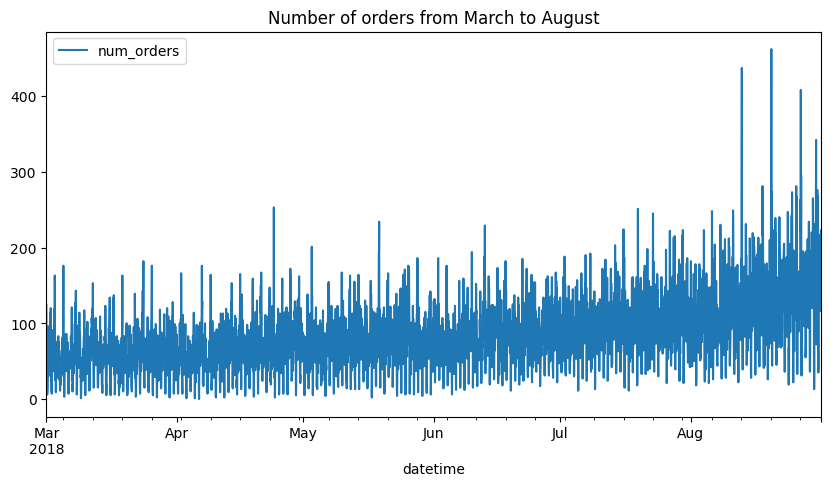

In [33]:
df.plot(figsize=(10,5))
plt.title('Number of orders from March to August')
plt.show()

There is a noticeable trend in the number of orders. Let's study the trend, seasonal component and remainder using decomposition.

In [23]:
decomposed = seasonal_decompose(df)

trend = decomposed.trend
seasonal = decomposed.seasonal
resid = decomposed.resid

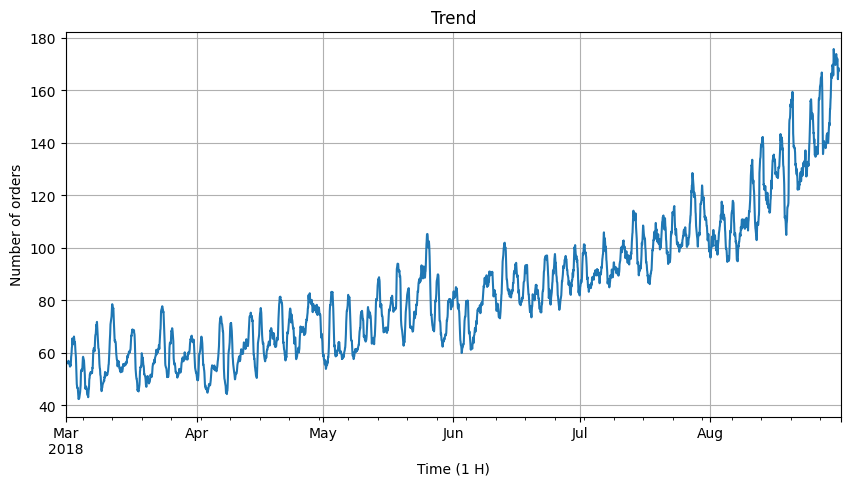

In [34]:
plot_graph(trend, 'Trend', 'Time (1 H)', 'Number of orders')

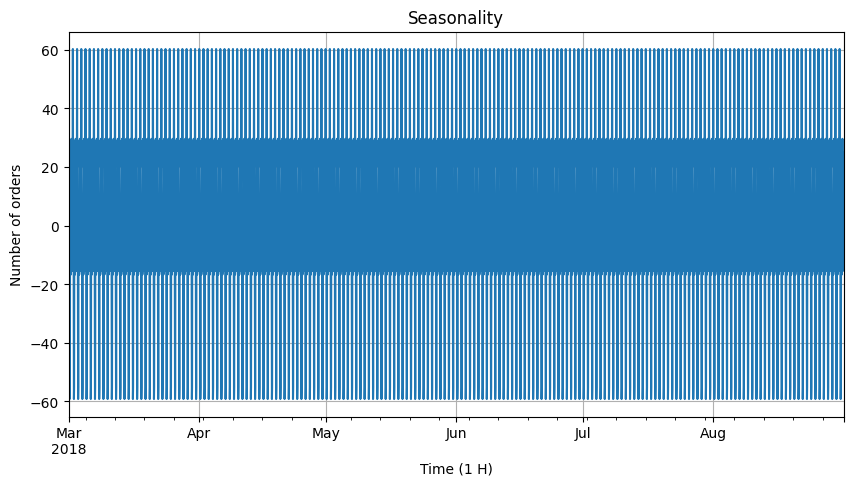

In [35]:
plot_graph(seasonal, 'Seasonality', 'Time (1 H)', 'Number of orders')

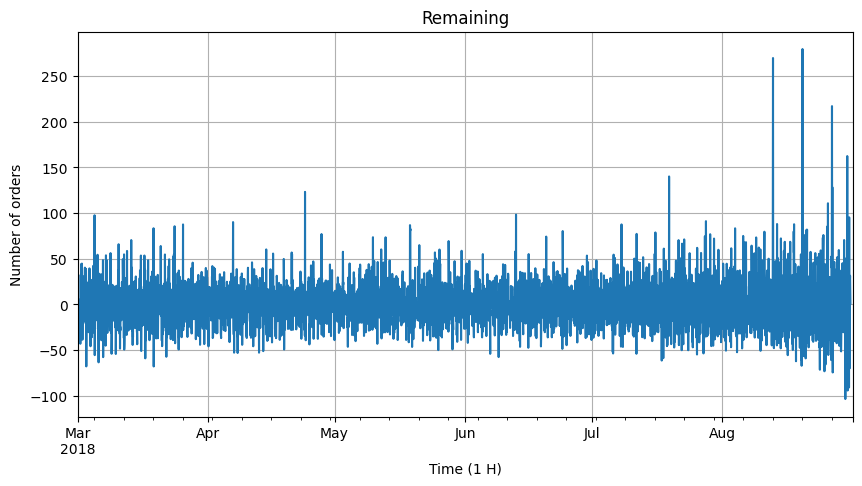

In [36]:
plot_graph(resid, 'Remaining', 'Time (1 H)', 'Number of orders')

Посмотрим на срез длиной в одну неделю

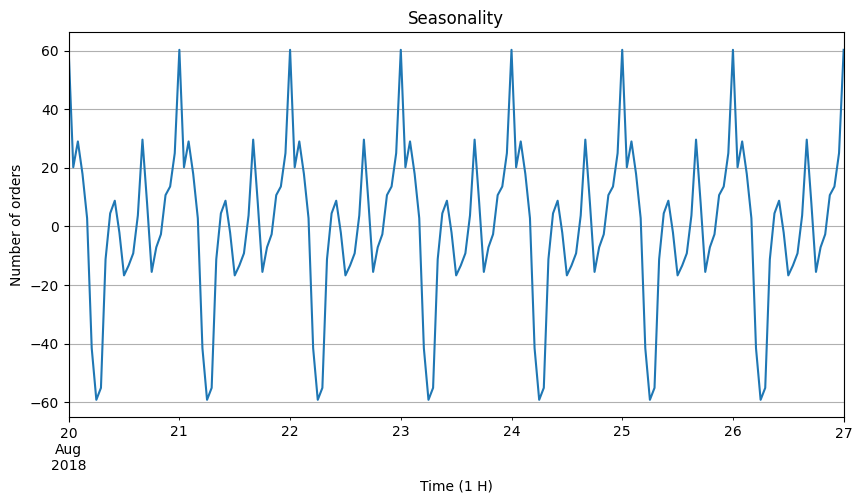

In [37]:
plot_graph(seasonal.loc['2018-08-20 00:00:00':'2018-08-27 00:00:00'], 'Seasonality', 'Time (1 H)', 'Number of orders')

Let's look at the data for one weekday (Tuesday):

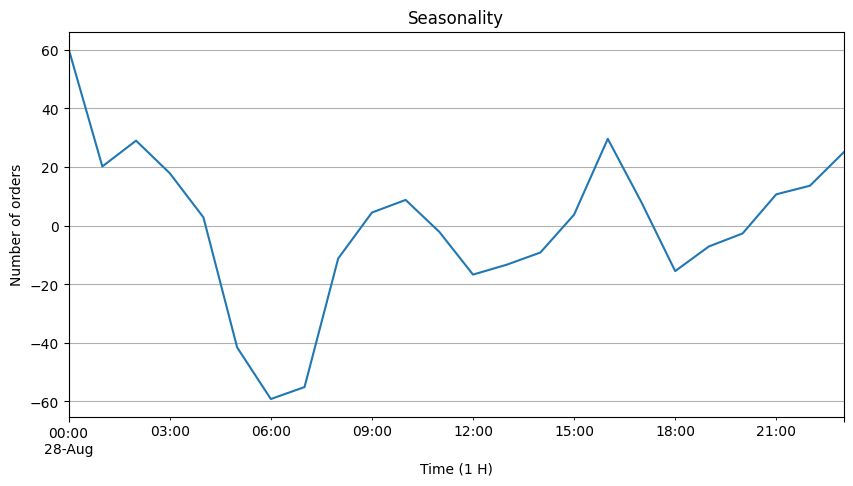

In [38]:
plot_graph(seasonal.loc['2018-08-28 00:00:00':'2018-08-28 23:59:00'], 'Seasonality', 'Time (1 H)', 'Number of orders')

Let's look at the data for one weekend (Saturday):

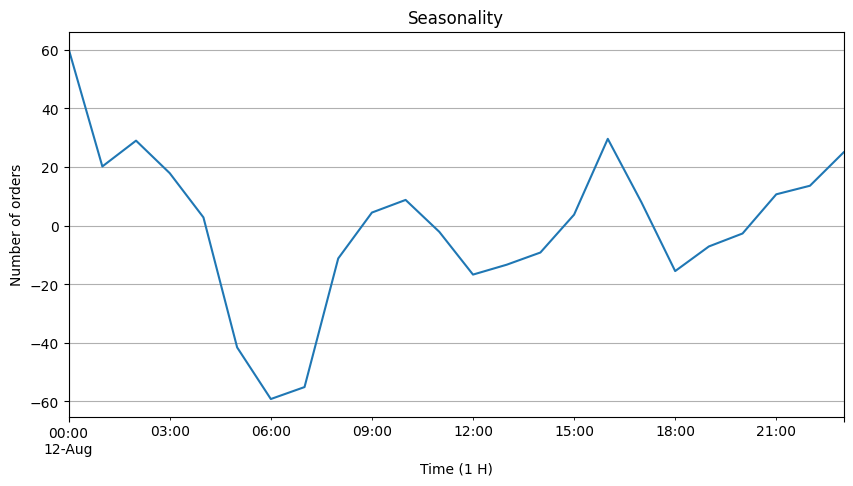

In [39]:
plot_graph(seasonal.loc['2018-08-12 00:00:00':'2018-08-12 23:59:00'], 'Seasonality', 'Time (1 H)', 'Number of orders')

**Conclusion:**

There is a general trend towards an increase in the number of orders. During the week, the dynamics are repeated day after day - by 6 am the number of orders is minimal, there are peaks around 9 am, 4 pm and midnight.

Let's resample by day and display the interval for a month, for example, April.

In [40]:
df_D = df_copy.resample('1D').sum()
decomposed_D = seasonal_decompose(df_D)
seasonal_D = decomposed_D.seasonal

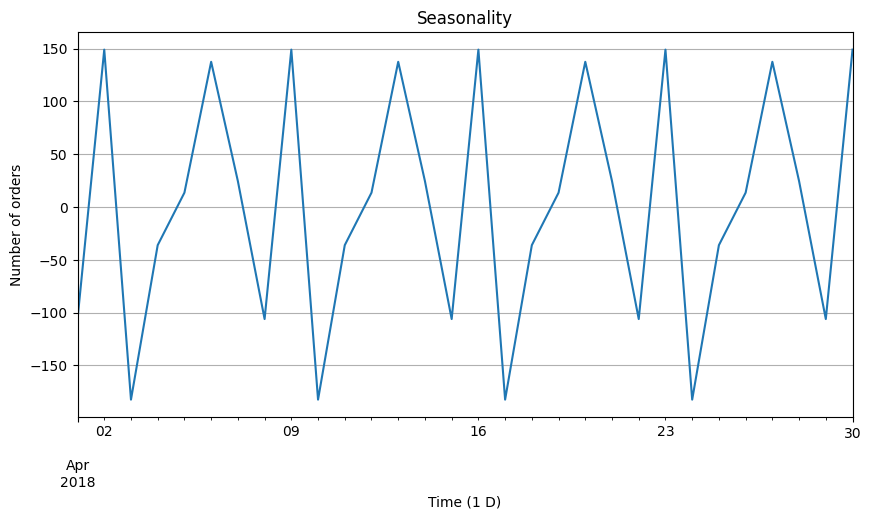

In [41]:
plot_graph(seasonal_D.loc['2018-04-01 00:00:00':'2018-04-30 23:59:00'], 'Seasonality', 'Time (1 D)', 'Number of orders')

You can see how seasonality changes by day of the week.

## Training

Let's write a function to create features, determine lagging values and a moving average.

In [42]:
def get_features(data, max_lag):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
            
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(1).mean()
    data.dropna(inplace=True)
    
    return data

Let's look at the autocorrelation of features by setting the number of shifts to 49

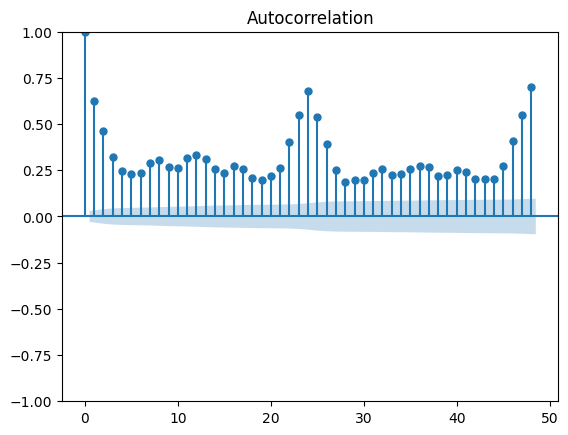

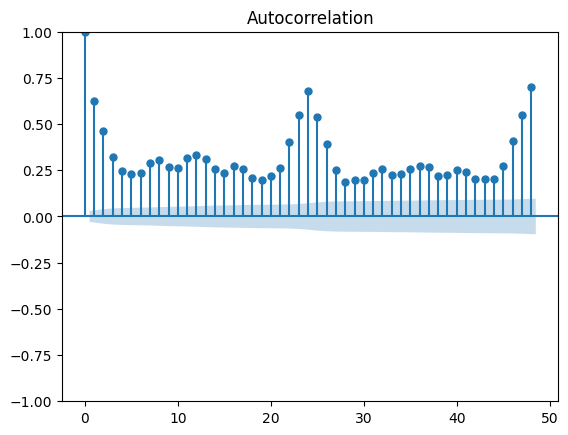

In [43]:
plot_acf(df, 
                                       ax=None, 
                                       lags=np.arange(49),                                         
                                       alpha=0.05, 
                                       use_vlines=True,
                                       adjusted=False, 
                                       fft=False,
                                       missing='none', 
                                       title='Autocorrelation', 
                                       zero=True,
                                       auto_ylims=False,
                                       bartlett_confint=True, 
                                       vlines_kwargs=None,
                                       )

In [44]:
df = get_features(df, 4)

In [45]:
df['lag_24'] = df['num_orders'].shift(24)
df.dropna(inplace=True)
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean,lag_24
datetime,,,,,,,,
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,75.0,66.0
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,64.0,43.0
2018-03-02 05:00:00,11,4,5,20.0,64.0,75.0,20.0,6.0
2018-03-02 06:00:00,11,4,6,11.0,20.0,64.0,11.0,12.0
2018-03-02 07:00:00,7,4,7,11.0,11.0,20.0,11.0,15.0


Divide into training and test samples in a ratio of 90:10, specify shuffle=False to save chronology.

In [46]:
features = df.drop(['num_orders'], axis=1) 
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

In [47]:
features_train.shape, features_test.shape


((3950, 7), (439, 7))

**Training various models.**



In [48]:
RMSE =[]

In [49]:
tscv = TimeSeriesSplit(n_splits=5)

**Linear Regression**

In [50]:
regression = LinearRegression()
regression.fit(features_train, target_train)

#Determining RMSE of a model using cross-validation

RMSE_LR = pd.Series(cross_val_score(
    regression, features_train, target_train ,scoring='neg_root_mean_squared_error',cv=tscv)).mean()*(-1)

print('Average quality of linear regression model on cross-validation:', RMSE_LR )


Average quality of linear regression model on cross-validation: 27.584346456707145


In [30]:
RMSE.append(RMSE_LR)

**RandomForestRegressor**

In [51]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
parameters = {'n_estimators':range(50,100,5), 'max_depth':range(0,10,2)}

In [52]:
search = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
search.fit(features_train, target_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(0, 10, 2),
                         'n_estimators': range(50, 100, 5)},
             scoring='neg_root_mean_squared_error')

In [53]:
search.best_params_

{'max_depth': 8, 'n_estimators': 50}

In [54]:
RMSE_RF = (-search.best_score_)
print("Lowest RMSE found:", RMSE_RF)

Lowest RMSE found: 26.46086988847467


In [55]:
RMSE.append(RMSE_RF)

**LightGBM**

In [56]:
model = LGBMRegressor(random_state=RANDOM_STATE, silent=True, num_threads = 10)

param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [40, 50, 80],
    'num_leaves' : [10,20,31]
}

search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', verbose=10)


In [57]:
%%capture
search.fit(features_train, target_train)

In [58]:
search.best_params_

{'learning_rate': 0.1, 'n_estimators': 80, 'num_leaves': 10}

In [59]:
RMSE_LGBM = (-search.best_score_)
print("Lowest RMSE found:", RMSE_LGBM)

Lowest RMSE found: 25.497194676658307


In [60]:
RMSE.append(RMSE_LGBM)

**CatBoost**

In [41]:
model = CatBoostRegressor(random_state=130324, silent=True)

param_grid = {
    'learning_rate': [0.01, 0.1],
     'depth': [8, 10],    
    'n_estimators': [120, 150],    
}


search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', verbose=10)

In [42]:
%%capture
search.fit(features_train, target_train)

In [43]:
print("Best parameters found:", search.best_params_)
RMSE_Catboost = (-search.best_score_)
print("Lowest RMSE found:", RMSE_Catboost)

Best parameters found: {'depth': 8, 'learning_rate': 0.1, 'n_estimators': 150}
Lowest RMSE found: 25.511558708487883


<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [44]:
RMSE.append(RMSE_Catboost)

Оформим все результаты в таблицу:

In [45]:
columns_df = ['RMSE']
df_quality = pd.DataFrame({'model': [ 'LR', 'RF', 'LGBM', 'CatBoost'], 'RMSE':RMSE })
df_quality

,model,RMSE
0,LR,27.575359
1,RF,26.460870
2,LGBM,25.497195
3,CatBoost,25.511559


**Conclusion**
The best model was the LGBM model with RMSE 26.596826 and hyperparameters {'learning_rate': 0.1, 'n_estimators': 50}

## Testing

In [46]:
RMSE_test= []

Let's check the data on a test sample with selected hyperparameters:

In [61]:
model_test = LGBMRegressor(learning_rate=0.1, 
                          random_state=12345,
                          n_estimators=50,
                          silent=True,
                          ) 

model_test.fit(features_train, target_train)

target_predict = model_test.predict(features_test)

RMSE_test_LGBM = mean_squared_error(target_test, target_predict) ** 0.5

print('Значение RMSE на тестовой выборке:', RMSE_test_LGBM)

Значение RMSE на тестовой выборке: 44.91434895184782


**Conclusion:** Data on taxi orders at airports was obtained and the task was set to predict the number of taxi orders for the next hour. Models for prediction were built - LinearRegression, RandomForestRegressor, LightGBM, Catboost. The lowest RMSE on the training set was shown by the LightGBM model - 25.497, on the test set - 44.9143.